<a href="https://colab.research.google.com/github/Justsecret123/One-Piece-Image-Classifier/blob/master/Model_with_Keras_Tuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import PIL
import IPython

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import preprocessing
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

import pathlib 
import zipfile

In [5]:
!pip install -q -U keras-tuner
import keras_tuner as kt

# Files

## Dataset download

In [6]:
data_path = 'drive/My Drive/Data.zip'
zip_ref = zipfile.ZipFile(data_path,'r')
zip_ref.extractall('/tmp/')

In [7]:
data_dir = pathlib.PosixPath('/tmp/Data')

## Images count

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg'))) + len(list(data_dir.glob('*/*.png'))) + len(list(data_dir.glob('*/*.jpeg'))) 
print(image_count)

1964


# Display some images

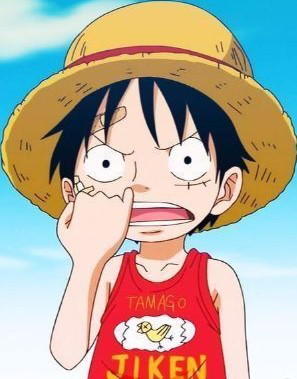

In [9]:
Luffy = list(data_dir.glob('Luffy/*'))
PIL.Image.open(str(Luffy[0]))

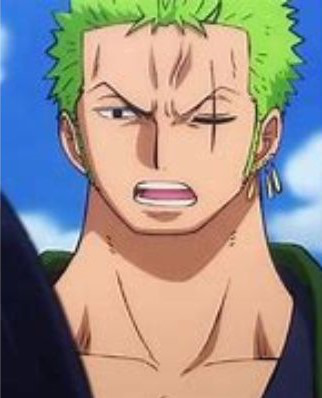

In [10]:
Zoro = list(data_dir.glob('Zoro/*'))
PIL.Image.open(str(Zoro[0]))

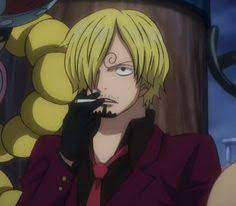

In [11]:
Sanji = list(data_dir.glob('Sanji/*'))
PIL.Image.open(str(Sanji[0]))

# Model builder

## Some parameters 

In [12]:
import random

In [13]:
random.seed()
seed = random.randint(0,100)

In [14]:
batch_size = 5
width = 180
height = 180

## Training dataset definition

In [15]:
train_dataset = preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(height,width),
    batch_size=batch_size
)

Found 1964 files belonging to 3 classes.
Using 1572 files for training.


In [16]:
classes_count = 3
class_names = train_dataset.class_names
print(class_names)

['Luffy', 'Sanji', 'Zoro']


## Validation dataset definition

In [17]:
val_dataset = preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(height, width),
    batch_size=batch_size
)

Found 1964 files belonging to 3 classes.
Using 392 files for validation.


# Data augmentation

In [18]:
data_augmentation = Sequential([
                                tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(height,width,3)),
                                tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                                tf.keras.layers.experimental.preprocessing.RandomZoom(0.2), 
                    ])

# Model builder

## Description

*   3 Convolutional layers followed by a batch normalization layer, then a MaxPooling layer followed by a batch normalization layer  
*   A flatten layer 
*   A dense layer which number of units will be decided by the hyper parameters
*   An activation layer (relu) which represents the final output: Probability of input(X) belonging to each class

Based on Sergey Ioffe and Christian Szegedy "Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift" research paper, there is no need to add a dropout layer since we've used a batch normalization layer. 

*Additional notes: reducing the number of layers : less validation and training set accuracy*





In [19]:
def model_builder(hp):
  
   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
   hp_learning_rate = hp.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])

   model = Sequential()

   model.add(layers.Conv2D( filters=15, kernel_size=3, activation="relu"))
   model.add(layers.BatchNormalization()) 
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Conv2D( filters=30, kernel_size=3, activation="relu"))
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Conv2D( filters=60, kernel_size=3, activation="relu"))
   model.add(layers.MaxPool2D())
   model.add(layers.BatchNormalization())
   model.add(layers.Flatten())
   model.add(layers.Dense( units=hp_units, activation="relu", kernel_regularizer=regularizers.L2(l2=0.001)))
   model.add(layers.BatchNormalization())
   model.add(layers.Dense( classes_count, activation="relu" ))
   model.add(layers.BatchNormalization())
   model.add(layers.Activation("sigmoid"))

   model.compile(
       optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
       loss="sparse_categorical_crossentropy", 
       metrics=["accuracy"]
  )
   
   return model

# Hypertuning 

## Callback function : *early stopping*

The validation loss will be the monitored parameter

In [20]:
stop_early = callbacks.EarlyStopping(monitor="val_loss", patience=5)

## Tuner

In [21]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3
)

In [22]:
tuner.search(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=[stop_early]
)

Trial 30 Complete [00h 00m 43s]
val_accuracy: 0.8239796161651611

Best val_accuracy So Far: 0.8239796161651611
Total elapsed time: 00h 13m 48s
INFO:tensorflow:Oracle triggered exit


## Get the optimal parameters

In [23]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Model fit

In [24]:
model = tuner.hypermodel.build(best_hps)

### Use early stopping to stop the training process if the validation accuracy stops increasing after 4 epochs, and restore the weights which minimize the validation accuracy

In [25]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=6, mode ="max", verbose=2, restore_best_weights=True)

In [29]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    verbose=1, 
    callbacks = [stop_early]
)

Epoch 1/30
315/315 [==============================] - 4s 11ms/step - loss: 1.0592 - accuracy: 0.8225 - val_loss: 1.1557 - val_accuracy: 0.7985
Epoch 2/30
315/315 [==============================] - 4s 11ms/step - loss: 1.0697 - accuracy: 0.8289 - val_loss: 1.1643 - val_accuracy: 0.7883
Epoch 3/30
315/315 [==============================] - 4s 11ms/step - loss: 1.1836 - accuracy: 0.7869 - val_loss: 1.1368 - val_accuracy: 0.8163
Epoch 4/30
315/315 [==============================] - 4s 11ms/step - loss: 1.0814 - accuracy: 0.8365 - val_loss: 1.2863 - val_accuracy: 0.7551
Epoch 5/30
315/315 [==============================] - 4s 11ms/step - loss: 1.1598 - accuracy: 0.8155 - val_loss: 1.1934 - val_accuracy: 0.8265
Epoch 6/30
315/315 [==============================] - 4s 11ms/step - loss: 1.1180 - accuracy: 0.8308 - val_loss: 1.0468 - val_accuracy: 0.8546
Epoch 7/30
315/315 [==============================] - 4s 11ms/step - loss: 0.9608 - accuracy: 0.8696 - val_loss: 1.0357 - val_accuracy: 0.8316

# Plotting the training results

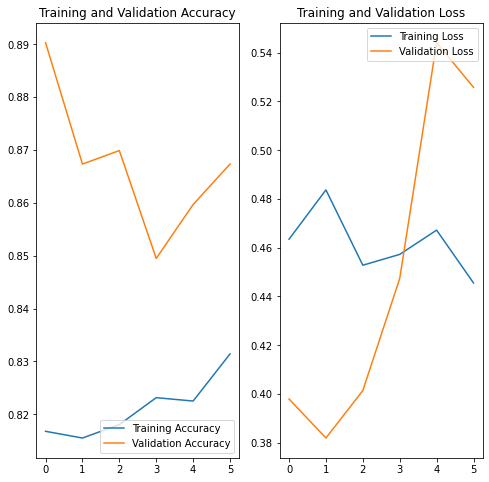

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(6)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Model summary 

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 178, 178, 15)      420       
_________________________________________________________________
batch_normalization (BatchNo (None, 178, 178, 15)      60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 89, 89, 15)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 89, 89, 15)        60        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 87, 87, 30)        4080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 43, 30)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 43, 43, 30)        1

# Predictions

In [33]:
from google.colab import files
from keras.preprocessing import image

In [34]:
class_names = train_dataset.class_names
class_names

['Luffy', 'Sanji', 'Zoro']

In [35]:
def prediction(): 
  for filename in uploaded.keys():

    path = "/content/" + filename
    im = image.load_img(path,target_size=(180,180))
    
    inputs = image.img_to_array(im)

    inputs = np.vstack([inputs])

    inputs = tf.expand_dims(inputs,axis=0) #Creates a batch

    
    score = model.predict(inputs) #Make a prediction based on input values
    score = np.squeeze(score)
    print("Image: ", path)
    for i in range (len(score)):
      print("\nProbability of being " + class_names[i] + \
              ": ", 100*score[i] , "%")

    object_score = np.max(score)  #np.argmax(score) :  returns the index with the highest score 
    object_class = class_names[np.argmax(score)]  #np.max(score) returns the highest probability of our input belonging to one of our classes
    

    plt.figure()
    plt.title("This image most likely belongs to " + str(object_class)+ \
              " category with a " + str(object_score) + " score.\n\n")
    
    plt.imshow(im)


    print("This image most likely belongs to " +str(object_class)+ \
          " category with a " + str(object_score) + " score. \n\n"
    )

In [36]:
uploaded = files.upload() 

Saving Luffy test.png to Luffy test.png
Saving Sanji test.jpg to Sanji test.jpg
Saving Zoro test.jpg to Zoro test.jpg


Image:  /content/Luffy test.png

Probability of being Luffy:  87.43684887886047 %

Probability of being Sanji:  14.180135726928711 %

Probability of being Zoro:  40.970635414123535 %
This image most likely belongs to Luffy category with a 0.8743685 score. 


Image:  /content/Sanji test.jpg

Probability of being Luffy:  22.078152000904083 %

Probability of being Sanji:  92.00767278671265 %

Probability of being Zoro:  59.83453392982483 %
This image most likely belongs to Sanji category with a 0.9200767 score. 


Image:  /content/Zoro test.jpg

Probability of being Luffy:  5.897992476820946 %

Probability of being Sanji:  17.819610238075256 %

Probability of being Zoro:  79.26580905914307 %
This image most likely belongs to Zoro category with a 0.7926581 score. 




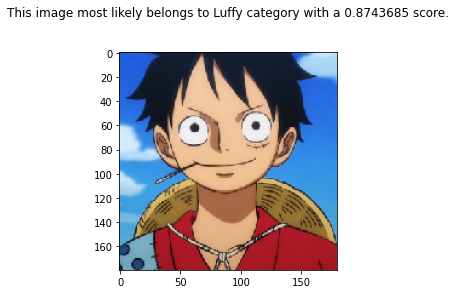

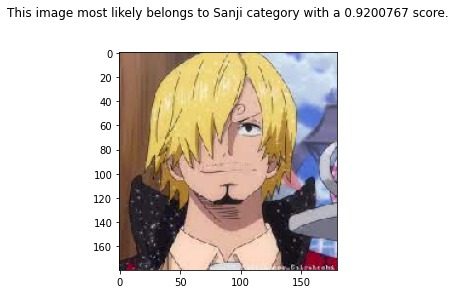

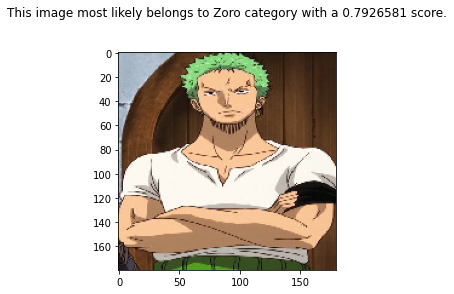

In [37]:
prediction()

In [38]:
model.save('drive/My Drive/One_Piece_Image_Classifier_Model.h5')

In [30]:
model.evaluate(x=val_dataset, return_dict=True)

79/79 [==============================] - 1s 7ms/step - loss: 0.9308 - accuracy: 0.8750


{'accuracy': 0.875, 'loss': 0.9308003187179565}